# Analysis and plotting of RBD depletions for sera samles

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import numpy as np
import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Titration ELISAs for pseudovirus assays

### Read ELISA Titration Data

In [6]:
elisa_pv_df_1 = pd.read_csv(config['elisa_pseudovirus_dil1'])

elisa_pv_df_1 = (pd.melt(elisa_pv_df_1, 
                        id_vars=['subject', 'timepoint', 'serum', 'depleted', 'round', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
               )

elisa_pv_df_1 = (elisa_pv_df_1
                .assign(depleted= pd.Categorical(elisa_pv_df_1['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(elisa_pv_df_1.head())  # display first few lines

,subject,timepoint,serum,depleted,round,ligand,date,dilution_factor,OD450,dilution
0,99C,27,99C-day-27,pre,no_depletion,RBD,220104,100,3.8843,0.01
1,99C,27,99C-day-27,post,round_1,RBD,220104,100,3.3874,0.01
2,99C,27,99C-day-27,post,round_2,RBD,220104,100,0.7362,0.01
3,99C,27,99C-day-27,post,round_3,RBD,220104,100,0.5800,0.01
4,99C,27,99C-day-27,post,round_4,RBD,220104,100,0.4996,0.01


In [7]:
elisa_pv_df_2 = pd.read_csv(config['elisa_pseudovirus_dil2'])

elisa_pv_df_2 = (pd.melt(elisa_pv_df_2, 
                        id_vars=['subject', 'timepoint', 'serum', 'depleted', 'round', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
               )

elisa_pv_df_2 = (elisa_pv_df_2
                .assign(depleted= pd.Categorical(elisa_pv_df_2['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(elisa_pv_df_2.head())  # display first few lines

,subject,timepoint,serum,depleted,round,ligand,date,dilution_factor,OD450,dilution
0,63C,10,63C-day-10,pre,no_depletion,RBD,220421,257,3.8713,0.003891
1,63C,10,63C-day-10,post,round_1,RBD,220421,257,NaN,0.003891
2,63C,10,63C-day-10,post,round_2,RBD,220421,257,0.3586,0.003891
3,63C,10,63C-day-10,post,round_3,RBD,220421,257,0.3615,0.003891
4,63C,10,63C-day-10,post,round_4,RBD,220421,257,0.3454,0.003891


In [8]:
frames = [elisa_pv_df_1,elisa_pv_df_2]
elisa_pv_df = pd.concat(frames)

In [9]:
#read in sample info
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates())

sample_information['sorted']=sample_information['subject_name'].str[:-1].astype(int)
sample_information = sample_information.sort_values('sorted')
sample_information

,day,age,vaccine,subject_name,serum_org,gender,serum,sorted
0,10,18-55y,Pfizer,63C,63C-day-10,Female,serum 1,63
1,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
2,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
3,18,>55y,Pfizer,108C,108C-day-18,Female,serum 4,108
4,10,18-55y,Pfizer,120C,120C-day-10,Female,serum 5,120
5,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180
6,9,>55y,Pfizer,192C,192C-day-9,Female,serum 7,192
7,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194
8,19,18-55y,Pfizer,215C,215C-day-19,Male,serum 9,215
9,29,18-55y,Pfizer,229C,229C-day-29,Female,serum 10,229


In [10]:
elisa_pv_df = pd.merge(elisa_pv_df, sample_information,
                    left_on='serum', right_on='serum_org')
elisa_pv_df.drop('serum_x', axis=1, inplace=True)
elisa_pv_df = elisa_pv_df.rename(columns={"serum_y": "serum"}, errors="raise")
elisa_pv_df

,subject,timepoint,depleted,round,ligand,date,dilution_factor,OD450,dilution,day,age,vaccine,subject_name,serum_org,gender,serum,sorted
0,99C,27,pre,no_depletion,RBD,220104,100,3.8843,0.010000,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
1,99C,27,post,round_1,RBD,220104,100,3.3874,0.010000,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
2,99C,27,post,round_2,RBD,220104,100,0.7362,0.010000,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
3,99C,27,post,round_3,RBD,220104,100,0.5800,0.010000,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
4,99C,27,post,round_4,RBD,220104,100,0.4996,0.010000,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,194C,8,pre,no_depletion,RBD,220421,20827,1.7747,0.000048,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194
246,194C,8,post,round_1,RBD,220421,20827,0.1556,0.000048,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194
247,194C,8,post,round_2,RBD,220421,20827,0.1293,0.000048,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194
248,194C,8,post,round_3,RBD,220421,20827,0.1069,0.000048,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194


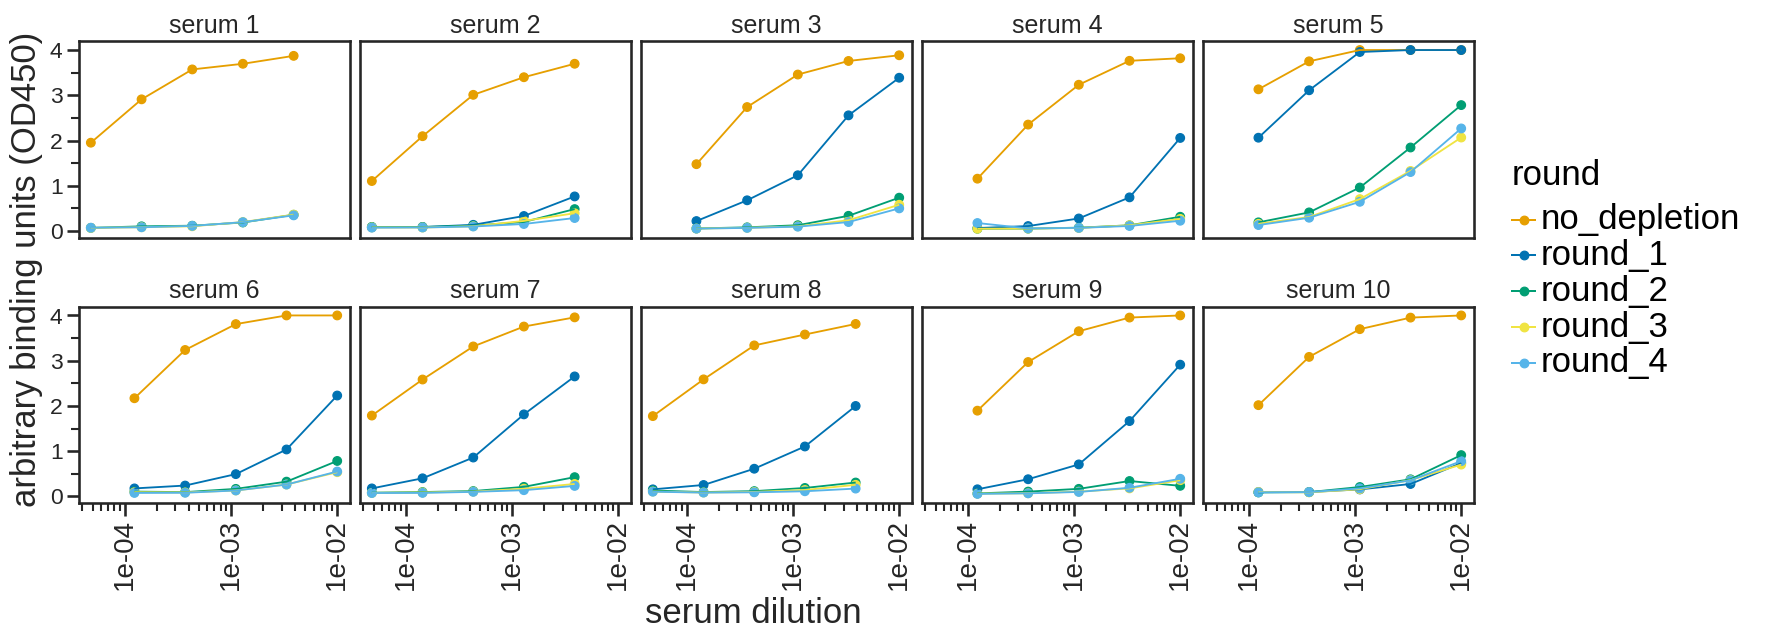

In [11]:
nconditions = elisa_pv_df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

p = (
    ggplot((elisa_pv_df
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=5) +
    theme(figure_size=(3 * ncol, 3 * nrow),
          axis_text_x=element_text(size=20,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          legend_text=element_text(size=25),
          legend_title=element_text(size=25),
          axis_title_x=element_text(size=25),
          axis_title_y=element_text(size=25)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )



_ = p.draw()

### ELISA for Live Virus RBD depletions

In [12]:
elisa_lv_df = pd.read_csv(config['elisa_livevirus'])

elisa_lv_df = (pd.melt(elisa_lv_df, 
                        id_vars=['subject', 'timepoint', 'serum', 'depleted', 'round', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
               )

elisa_lv_df = (elisa_lv_df
                .assign(depleted= pd.Categorical(elisa_lv_df['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(elisa_lv_df.head())  # display first few lines

,subject,timepoint,serum,depleted,round,ligand,date,dilution_factor,OD450,dilution
0,64C,15,64C-day-15,pre,no_depletion,RBD,220421,257,3.6872,0.003891
1,64C,15,64C-day-15,post,round_1,RBD,220421,257,0.0919,0.003891
2,64C,15,64C-day-15,post,round_2,RBD,220421,257,0.0821,0.003891
3,64C,15,64C-day-15,post,round_3,RBD,220421,257,0.0968,0.003891
4,64C,15,64C-day-15,post,round_4,RBD,220421,257,0.0961,0.003891


In [13]:
elisa_lv_df = pd.merge(elisa_lv_df, sample_information,
                    left_on='serum', right_on='serum_org')

elisa_lv_df
elisa_lv_df.drop('serum_x', axis=1, inplace=True)
elisa_lv_df = elisa_lv_df.rename(columns={"serum_y": "serum"}, errors="raise")
elisa_lv_df

,subject,timepoint,depleted,round,ligand,date,dilution_factor,OD450,dilution,day,age,vaccine,subject_name,serum_org,gender,serum,sorted
0,64C,15,pre,no_depletion,RBD,220421,257,3.6872,0.003891,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
1,64C,15,post,round_1,RBD,220421,257,0.0919,0.003891,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
2,64C,15,post,round_2,RBD,220421,257,0.0821,0.003891,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
3,64C,15,post,round_3,RBD,220421,257,0.0968,0.003891,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
4,64C,15,post,round_4,RBD,220421,257,0.0961,0.003891,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,180C,36,pre,no_depletion,RBD,220421,20817,1.2065,0.000048,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180
96,180C,36,post,round_1,RBD,220421,20817,0.0704,0.000048,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180
97,180C,36,post,round_2,RBD,220421,20817,0.0684,0.000048,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180
98,180C,36,post,round_3,RBD,220421,20817,0.0625,0.000048,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180


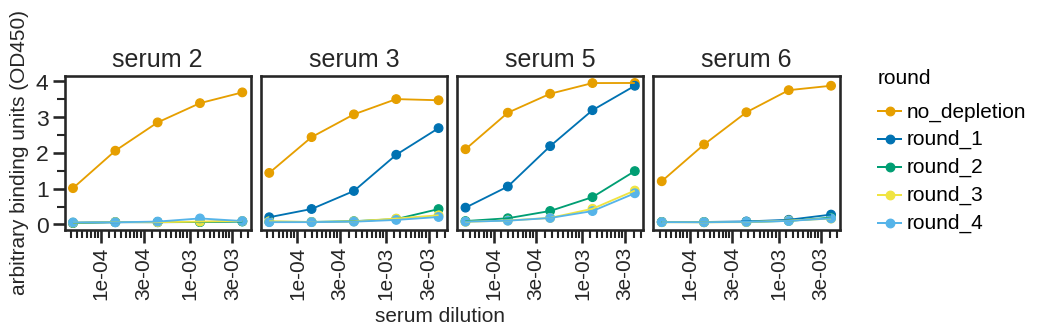

In [14]:
nconditions = elisa_pv_df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

colours = ('#E69F00','#0072B2','#009E73','#F0E442','#56B4E9',)

p = (
    ggplot((elisa_lv_df
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
           ),
           aes('dilution', 
               'OD450', 
               color='round'
              )) +
    geom_point(size=3) +
    geom_path(aes(color='round'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=5) +
    theme(figure_size=(10,2),
          axis_text_x=element_text(size=15,angle=90),
          subplots_adjust={'hspace':0.35},
          strip_background_x=element_blank(),
          legend_text=element_text(size=15),
          legend_title=element_text(size=15),
          axis_title_x=element_text(size=15),
          axis_title_y=element_text(size=15)
         ) +
    scale_color_manual(values=colours) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )



_ = p.draw()